In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from CHAMP.DataLoader import LoadData, LoadFaceDB
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayConvergenceClassif
from CHAMP.CHAMP_Layer import ConvMP
from CHAMP.DataTools import GenerateGabor, Rebuilt, ContrastNormalized, ChangeBatchSize
import matplotlib.pyplot as plt
from CHAMP.LowLevel import conv
from CHAMP.Classif_Layer import Classif_Layer
import os
home = os.getenv('HOME')
from CHAMP.DataTools import SaveNetwork, LoadNetwork

In [2]:
l0 = 100
nb_dico = 8
dico_size = (7,7)
image_size = (92,92)
OutputL1_size =tuple(image_size[i]-dico_size[i]+1 for i in range(len(dico_size)))
saving_path = 'Records/'

# On Face DataBase

## Load the DataBase

In [3]:
path = "../../../Science/These/Rapport d'avancement/database/Face_DataBase/"
#path = home + "/science/VB_These/Rapport d'avancement/database/Face_DataBase/"
training_set,testing_set = LoadData('Face',data_path=path,avg_size=(5,5))

In [4]:
print(training_set[0].size())

torch.Size([1, 400, 1, 92, 92])


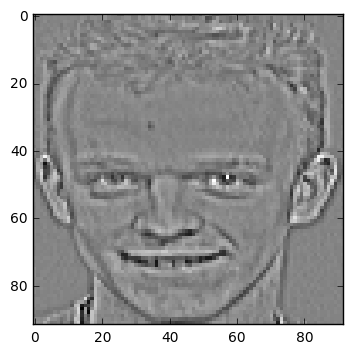

In [5]:
plot = plt.imshow(training_set[0][0,0,0,:,:].numpy(),cmap='gray')

## Generate Filters

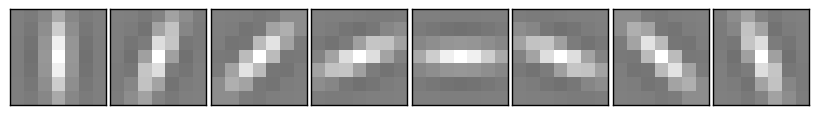

In [6]:
DicoGabor = GenerateGabor(nb_dico=nb_dico,dico_size=dico_size,sigma=1\
                          ,lambd=5,gamma=0.5,psi=0)
DisplayDico(DicoGabor)

## Coding

In [7]:
code = ConvMP(image_input=training_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=l0,
                modulation=None, verbose=0, train=True, doSym='pos', mask=None,\
                MaskMod='Residual')

In [8]:
reconstructed_image = Rebuilt(training_set[0][0,:,:,:,:],code,DicoGabor)

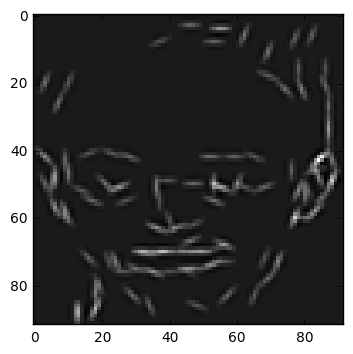

In [9]:
plt.imshow(reconstructed_image[0,0,:,:].numpy(),cmap='gray')

In [10]:
residual=training_set[0][0,:,:,:,:]-reconstructed_image

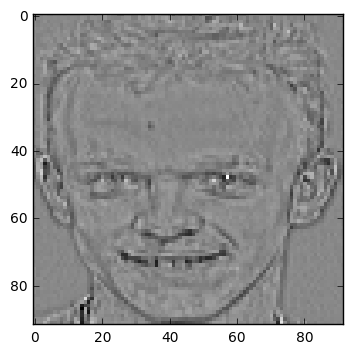

In [11]:
plt.imshow(residual[0,0,:,:].numpy(),cmap='gray')

## Classifying Raw Data

In [29]:
SaveExp = False

In [30]:
batch_training_set = ChangeBatchSize(training_set,batch_size=400)

In [31]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_Raw = Classif_Layer(nb_dico=1,size_image=image_size,nb_categories=40, verbose=0)
    Classifier_Raw = Classifier_Raw.train_classif(batch_training_set,nb_epoch=30000,data_test_loader=training_set,lr=0.005)
    SaveNetwork(Classifier_Raw, saving_path+'FaceDB_ClassifRaw.pkl')
else : 
    Classifier_Raw = LoadNetwork(saving_path+'FaceDB_ClassifRaw.pkl')

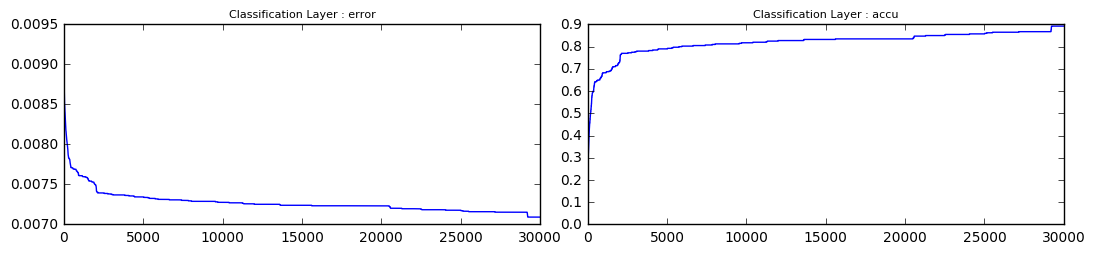

In [32]:
DisplayConvergenceClassif(Classifier_Raw, to_display=['error','accu'])

In [33]:
print('best accuracy : {0}%'.format(Classifier_Raw.accuracy_list[-1]*100))

best accuracy : 89.25%


## Classifying Output of One CHAMP Layer

In [20]:
SaveExp = False

In [21]:
output_Layer1 = (code.to_dense().unsqueeze(0),training_set[1])

In [22]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CHAMP = Classif_Layer(nb_dico=8,size_image=OutputL1_size, nb_categories=40, verbose=0)
    Classifier_CHAMP = Classifier_CHAMP.train_classif(output_Layer1,nb_epoch=500,\
                                                      data_test_loader=output_Layer1,lr=0.001)
    SaveNetwork(Classifier_CHAMP, saving_path+'FaceDB_ClassifCHAMP.pkl')
else : 
    Classifier_CHAMP = LoadNetwork(saving_path+'FaceDB_ClassifCHAMP.pkl')

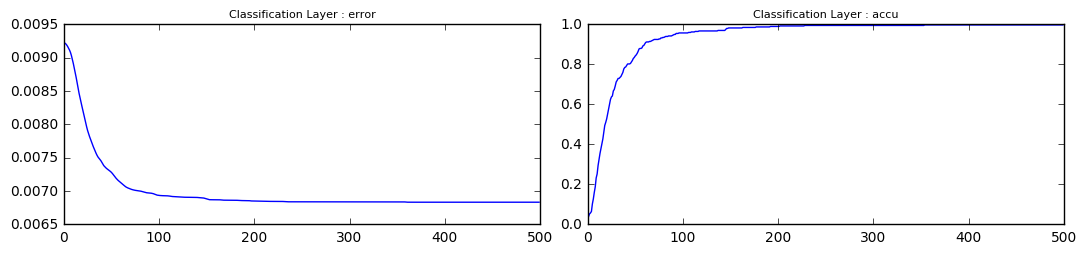

In [23]:
DisplayConvergenceClassif(Classifier_CHAMP, to_display=['error','accu'])

In [24]:
print('best accuracy : {0}%'.format(Classifier_CHAMP.accuracy_list[-1]*100))

best accuracy : 99.75%


## Classyfing output of Convolutional Layer

In [34]:
SaveExp = True

In [35]:
Output = conv(training_set[0][0,:,:,:,:], DicoGabor)
print(Output.size())
output_ConvLayer1 = (Output.unsqueeze(0),training_set[1])

torch.Size([400, 8, 86, 86])


In [36]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CONV = Classif_Layer(nb_dico=8,size_image=OutputL1_size, nb_categories=40, verbose=0)
    Classifier_CONV = Classifier_CONV.train_classif(output_ConvLayer1,nb_epoch=30000,\
                                                    data_test_loader=output_ConvLayer1,lr=0.001)
    SaveNetwork(Classifier_CONV, saving_path+'FaceDB_ClassifConv.pkl')
else : 
    Classifier_CONV = LoadNetwork(saving_path+'FaceDB_ClassifConv.pkl')

file saved


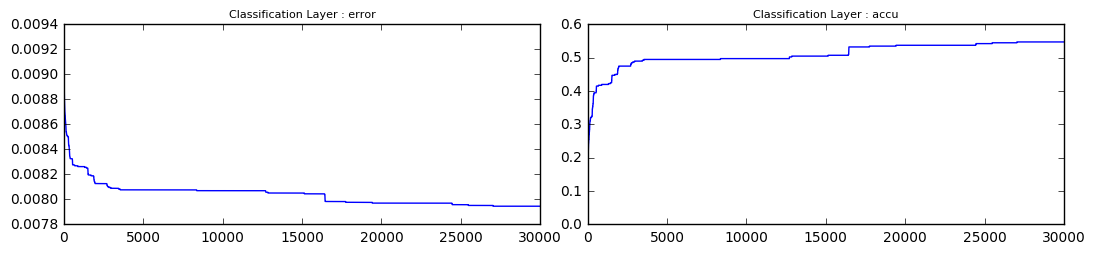

In [37]:
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])

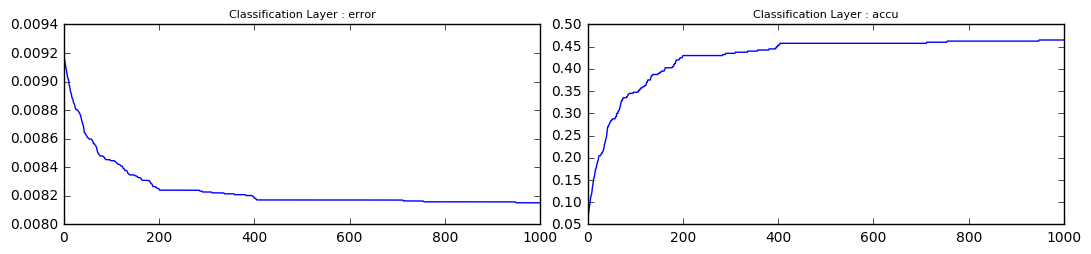

In [28]:
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])

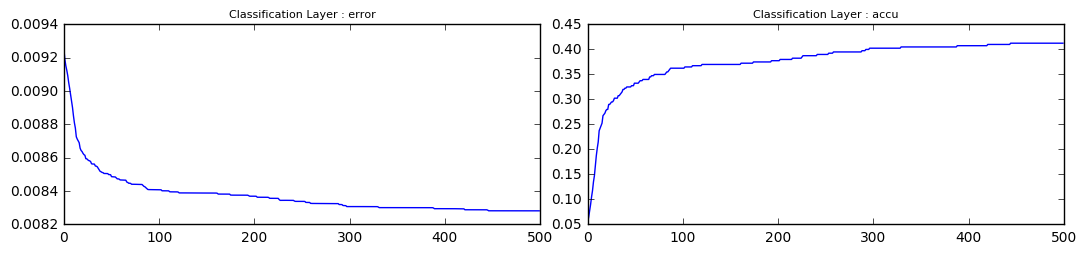

In [19]:
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])

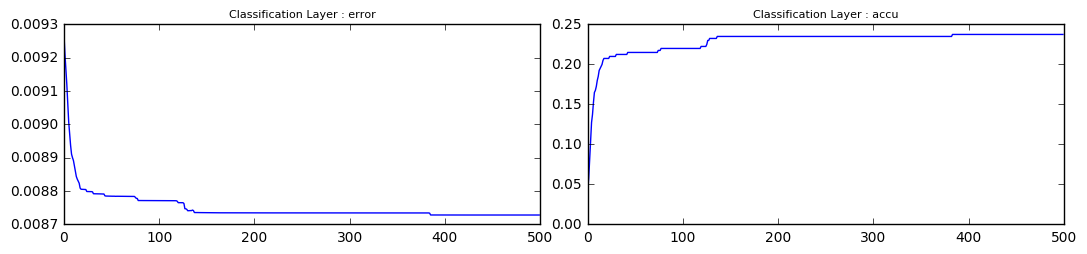

In [15]:
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])

In [16]:
print('best accuracy : {0}%'.format(Classifier_CONV.accuracy_list[-1]*100))

best accuracy : 23.75%
